In [543]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from copy import deepcopy
from pathlib import Path
from scipy.signal import resample

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [2]:
def generate_cdr1_to_cdr3_pdb(path):
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        chain_range = slice(21, 22)
        res_range = slice(23, 26)
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
            l_chain = line[l_pos:l_pos+1]
            
            # Obtaining the CDR1 to CDR3 lines for both chains
            for i, line in enumerate(content[header_lines:]):
                if (line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range) or (line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range):
                    idx_list.append(i+header_lines)
            
                    
    # Creating new file
    with open(new_path, 'w') as f_new:
        f_new.writelines([content[l] for l in idx_list])

In [3]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
entries = list(df['pdb'])
affinity = list(df['affinity'])
modes = 15 # 'all' if no limit is desired, otherwise a number is required
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate
#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input)
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))
    
#    if os.path.exists(path):
#        os.remove(path)

In [4]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/predicting-affinity/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in entries:
        idx = entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(np.load(f)[:80, :80])
        kds.append(np.log10(np.float32(affinity[idx])))

# converting the list to numpy array
#train_x = np.array(np.triu(imgs))
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

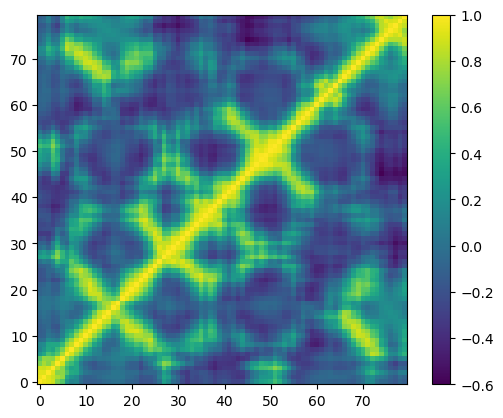

In [5]:
plt.imshow(train_x[0], origin='lower')
plt.colorbar()

In [6]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.0001)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((392, 80, 80), (392,)), ((1, 80, 80), (1,)))

In [7]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([392, 1, 80, 80]), torch.Size([392, 1]))

In [8]:
len(list(train_x))

392

In [9]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1, 1, 80, 80]), torch.Size([1, 1]))

In [504]:
class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, 5, 21)
        self.conv1.weight.data = torch.tril(self.conv1.weight.data) + torch.transpose(torch.tril(self.conv1.weight.data), 2, 3)
        #self.conv1.weight.data = torch.transpose(self.conv1.weight.data, 2, 3)
        self.pool = MaxPool2d(4, 4)
        self.conv2 = Conv2d(16, 32, 3)
        self.conv2.weight.data = torch.tril(self.conv2.weight.data) + torch.transpose(torch.tril(self.conv2.weight.data), 2, 3)
        #self.conv2.weight.data = torch.transpose(self.conv2.weight.data, 2, 3)
        self.relu = ReLU()
        self.fc1 = Linear(1125, 1)
        self.fc2 = Linear(128, 1)
        self.dropit = Dropout(p=0.2)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) #shape of x is (b_s, 28,28,132)
        x = self.relu(x)
        x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        #x = self.conv2(x) # shape(b_s, 10x10x64)
        #x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.fc1(x)
        #x = self.dropit(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float()


In [505]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
optimizer = AdamW(model.parameters(), lr=4e-4)
#optimizer = AdaBelief(model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple=False, rectify=False)
#optimizer = SGD(model.parameters(), lr=8e-4)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=3e-8, factor=1e-4)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

MultiLabelNN(
  (conv1): Conv2d(1, 5, kernel_size=(21, 21), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=1125, out_features=1, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropit): Dropout(p=0.2, inplace=False)
)


In [506]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 32
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    
    permutation = torch.randperm(x_train.size()[0])

    for i in range(0,x_train.size()[0], batch_size):
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        # prediction for training and validation set
        output_train = model(batch_x)
        output_val = model(x_val)

        # computing the training and validation loss
        loss_train = criterion(output_train, batch_y)
        loss_val = criterion(output_val, y_val)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        #scheduler.step(loss_val)
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)
        
    return tr_loss, loss_val


In [507]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [529]:
# defining the number of epochs
n_max_epochs = 1000

# training the model
for epoch in range(n_max_epochs):
    tr_loss, val_loss = train(epoch)
    if tr_loss < 0.05 and val_loss < 0.2:
        break

Epoch :  1 	 train loss:  2.0594193789423727 val loss : tensor(4.1458, grad_fn=<MseLossBackward0>)
tensor([[-7.6279]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  2 	 train loss:  2.1897984816103566 val loss : tensor(5.4790, grad_fn=<MseLossBackward0>)
tensor([[-7.9325]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  3 	 train loss:  2.15368821669598 val loss : tensor(4.1523, grad_fn=<MseLossBackward0>)
tensor([[-7.6295]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  4 	 train loss:  2.030003138950893 val loss : tensor(4.3598, grad_fn=<MseLossBackward0>)
tensor([[-7.6798]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  5 	 train loss:  2.1477809682184335 val loss : tensor(4.3681, grad_fn=<MseLossBackward0>)
tensor([[-7.6817]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  6 	 train loss:  2.171068892187002 val loss : tensor(4.6295, grad_fn=<MseLossBackward0>)
tensor([[-7.7434]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  7 	 t

Epoch :  51 	 train loss:  2.1378035642662825 val loss : tensor(3.3072, grad_fn=<MseLossBackward0>)
tensor([[-7.4103]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  52 	 train loss:  2.0234968613605107 val loss : tensor(2.1475, grad_fn=<MseLossBackward0>)
tensor([[-7.0572]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  53 	 train loss:  1.9851761642767456 val loss : tensor(3.2568, grad_fn=<MseLossBackward0>)
tensor([[-7.3964]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  54 	 train loss:  1.9470788556702285 val loss : tensor(3.8963, grad_fn=<MseLossBackward0>)
tensor([[-7.5657]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  55 	 train loss:  1.963739594634698 val loss : tensor(2.6775, grad_fn=<MseLossBackward0>)
tensor([[-7.2281]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  56 	 train loss:  1.9983491313700774 val loss : tensor(2.4291, grad_fn=<MseLossBackward0>)
tensor([[-7.1503]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch

Epoch :  101 	 train loss:  2.0291367647599197 val loss : tensor(1.2842, grad_fn=<MseLossBackward0>)
tensor([[-6.7250]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  102 	 train loss:  2.0807715046162505 val loss : tensor(1.3149, grad_fn=<MseLossBackward0>)
tensor([[-6.7384]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  103 	 train loss:  1.93211673230541 val loss : tensor(2.2803, grad_fn=<MseLossBackward0>)
tensor([[-7.1018]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  104 	 train loss:  1.9839292886305828 val loss : tensor(2.0796, grad_fn=<MseLossBackward0>)
tensor([[-7.0339]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  105 	 train loss:  1.8962570550490396 val loss : tensor(2.8907, grad_fn=<MseLossBackward0>)
tensor([[-7.2920]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  106 	 train loss:  1.9373189186563295 val loss : tensor(3.2749, grad_fn=<MseLossBackward0>)
tensor([[-7.4014]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])


Epoch :  151 	 train loss:  1.9651432329294631 val loss : tensor(1.3846, grad_fn=<MseLossBackward0>)
tensor([[-6.7684]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  152 	 train loss:  1.8156912667410714 val loss : tensor(0.9210, grad_fn=<MseLossBackward0>)
tensor([[-6.5514]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  153 	 train loss:  1.9866013624230208 val loss : tensor(3.2083, grad_fn=<MseLossBackward0>)
tensor([[-7.3829]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  154 	 train loss:  2.084720241780184 val loss : tensor(3.5630, grad_fn=<MseLossBackward0>)
tensor([[-7.4793]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  155 	 train loss:  2.044764898261245 val loss : tensor(4.5763, grad_fn=<MseLossBackward0>)
tensor([[-7.7310]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  156 	 train loss:  1.9155167657501844 val loss : tensor(1.8371, grad_fn=<MseLossBackward0>)
tensor([[-6.9472]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])


Epoch :  201 	 train loss:  1.6920570354072415 val loss : tensor(2.5386, grad_fn=<MseLossBackward0>)
tensor([[-7.1851]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  202 	 train loss:  1.7596460118585702 val loss : tensor(1.5730, grad_fn=<MseLossBackward0>)
tensor([[-6.8460]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  203 	 train loss:  1.6763182562224719 val loss : tensor(1.2623, grad_fn=<MseLossBackward0>)
tensor([[-6.7153]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  204 	 train loss:  1.6975539168533014 val loss : tensor(3.1746, grad_fn=<MseLossBackward0>)
tensor([[-7.3735]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  205 	 train loss:  1.6972268795480534 val loss : tensor(2.5463, grad_fn=<MseLossBackward0>)
tensor([[-7.1875]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  206 	 train loss:  1.7376369164914502 val loss : tensor(1.7607, grad_fn=<MseLossBackward0>)
tensor([[-6.9187]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]]

Epoch :  251 	 train loss:  1.603757108960833 val loss : tensor(1.2674, grad_fn=<MseLossBackward0>)
tensor([[-6.7175]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  252 	 train loss:  1.530973833434436 val loss : tensor(0.9590, grad_fn=<MseLossBackward0>)
tensor([[-6.5711]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  253 	 train loss:  1.7083300035827016 val loss : tensor(1.7349, grad_fn=<MseLossBackward0>)
tensor([[-6.9089]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  254 	 train loss:  1.5976359698237206 val loss : tensor(2.2599, grad_fn=<MseLossBackward0>)
tensor([[-7.0951]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  255 	 train loss:  1.6030691448523073 val loss : tensor(1.5734, grad_fn=<MseLossBackward0>)
tensor([[-6.8461]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  256 	 train loss:  1.5383299321544412 val loss : tensor(1.0445, grad_fn=<MseLossBackward0>)
tensor([[-6.6137]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])


Epoch :  301 	 train loss:  1.5182479109082903 val loss : tensor(1.6907, grad_fn=<MseLossBackward0>)
tensor([[-6.8920]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  302 	 train loss:  1.4752586715075433 val loss : tensor(1.7651, grad_fn=<MseLossBackward0>)
tensor([[-6.9203]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  303 	 train loss:  1.4881135152310743 val loss : tensor(1.4334, grad_fn=<MseLossBackward0>)
tensor([[-6.7890]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  304 	 train loss:  1.5305800924495776 val loss : tensor(0.6893, grad_fn=<MseLossBackward0>)
tensor([[-6.4220]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  305 	 train loss:  1.5161693144817743 val loss : tensor(0.8617, grad_fn=<MseLossBackward0>)
tensor([[-6.5200]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  306 	 train loss:  1.5176582677023749 val loss : tensor(1.7040, grad_fn=<MseLossBackward0>)
tensor([[-6.8971]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]]

Epoch :  351 	 train loss:  1.3990543861778417 val loss : tensor(1.2716, grad_fn=<MseLossBackward0>)
tensor([[-6.7194]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  352 	 train loss:  1.4506134013740386 val loss : tensor(0.6990, grad_fn=<MseLossBackward0>)
tensor([[-6.4278]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  353 	 train loss:  1.3781728111967748 val loss : tensor(0.8142, grad_fn=<MseLossBackward0>)
tensor([[-6.4941]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  354 	 train loss:  1.4326062445737877 val loss : tensor(1.7551, grad_fn=<MseLossBackward0>)
tensor([[-6.9166]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  355 	 train loss:  1.3393268439234518 val loss : tensor(2.4820, grad_fn=<MseLossBackward0>)
tensor([[-7.1672]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  356 	 train loss:  1.3315831982359594 val loss : tensor(0.9103, grad_fn=<MseLossBackward0>)
tensor([[-6.5459]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]]

Epoch :  401 	 train loss:  1.2972424614186189 val loss : tensor(1.1235, grad_fn=<MseLossBackward0>)
tensor([[-6.6517]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  402 	 train loss:  1.2409659453800748 val loss : tensor(1.6598, grad_fn=<MseLossBackward0>)
tensor([[-6.8801]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  403 	 train loss:  1.2666086712662055 val loss : tensor(1.5688, grad_fn=<MseLossBackward0>)
tensor([[-6.8443]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  404 	 train loss:  1.2733880938315878 val loss : tensor(1.8215, grad_fn=<MseLossBackward0>)
tensor([[-6.9414]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  405 	 train loss:  1.2118266942549725 val loss : tensor(1.7708, grad_fn=<MseLossBackward0>)
tensor([[-6.9225]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  406 	 train loss:  1.2169962561860377 val loss : tensor(0.8996, grad_fn=<MseLossBackward0>)
tensor([[-6.5402]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]]

Epoch :  451 	 train loss:  1.1586746245014425 val loss : tensor(1.0835, grad_fn=<MseLossBackward0>)
tensor([[-6.6327]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  452 	 train loss:  1.160592001311633 val loss : tensor(1.1342, grad_fn=<MseLossBackward0>)
tensor([[-6.6567]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  453 	 train loss:  1.1674984036659708 val loss : tensor(0.5509, grad_fn=<MseLossBackward0>)
tensor([[-6.3340]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  454 	 train loss:  1.263503176825387 val loss : tensor(1.1345, grad_fn=<MseLossBackward0>)
tensor([[-6.6569]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  455 	 train loss:  1.1258703859484924 val loss : tensor(1.0947, grad_fn=<MseLossBackward0>)
tensor([[-6.6380]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  456 	 train loss:  1.1485934500791586 val loss : tensor(0.4787, grad_fn=<MseLossBackward0>)
tensor([[-6.2836]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])


Epoch :  501 	 train loss:  1.0461075549222985 val loss : tensor(1.7847, grad_fn=<MseLossBackward0>)
tensor([[-6.9277]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  502 	 train loss:  1.1144575148212668 val loss : tensor(2.6171, grad_fn=<MseLossBackward0>)
tensor([[-7.2095]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  503 	 train loss:  1.1229540474560797 val loss : tensor(2.5350, grad_fn=<MseLossBackward0>)
tensor([[-7.1839]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  504 	 train loss:  1.0881459323727356 val loss : tensor(1.9153, grad_fn=<MseLossBackward0>)
tensor([[-6.9757]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  505 	 train loss:  1.051659768941451 val loss : tensor(1.4183, grad_fn=<MseLossBackward0>)
tensor([[-6.7827]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  506 	 train loss:  1.0263009752546035 val loss : tensor(1.8957, grad_fn=<MseLossBackward0>)
tensor([[-6.9686]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  551 	 train loss:  1.0010782455911442 val loss : tensor(2.4652, grad_fn=<MseLossBackward0>)
tensor([[-7.1618]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  552 	 train loss:  0.992541790008545 val loss : tensor(1.5202, grad_fn=<MseLossBackward0>)
tensor([[-6.8247]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  553 	 train loss:  0.9694189368462076 val loss : tensor(1.5419, grad_fn=<MseLossBackward0>)
tensor([[-6.8335]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  554 	 train loss:  0.9546873131576851 val loss : tensor(0.7964, grad_fn=<MseLossBackward0>)
tensor([[-6.4842]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  555 	 train loss:  0.9135873074434242 val loss : tensor(0.9859, grad_fn=<MseLossBackward0>)
tensor([[-6.5847]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  556 	 train loss:  0.9340529782431467 val loss : tensor(0.9386, grad_fn=<MseLossBackward0>)
tensor([[-6.5606]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  601 	 train loss:  0.9075223669713857 val loss : tensor(1.0204, grad_fn=<MseLossBackward0>)
tensor([[-6.6019]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  602 	 train loss:  0.9087306674645872 val loss : tensor(1.4940, grad_fn=<MseLossBackward0>)
tensor([[-6.8141]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  603 	 train loss:  1.0040162436816156 val loss : tensor(0.9822, grad_fn=<MseLossBackward0>)
tensor([[-6.5828]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  604 	 train loss:  0.891837470385493 val loss : tensor(1.0792, grad_fn=<MseLossBackward0>)
tensor([[-6.6306]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  605 	 train loss:  0.9161504239452128 val loss : tensor(1.4173, grad_fn=<MseLossBackward0>)
tensor([[-6.7823]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  606 	 train loss:  0.9244888315395432 val loss : tensor(1.0201, grad_fn=<MseLossBackward0>)
tensor([[-6.6018]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  651 	 train loss:  0.8032255610641167 val loss : tensor(0.3510, grad_fn=<MseLossBackward0>)
tensor([[-6.1842]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  652 	 train loss:  0.8527549675532751 val loss : tensor(0.4105, grad_fn=<MseLossBackward0>)
tensor([[-6.2325]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  653 	 train loss:  0.8583716178426938 val loss : tensor(0.3043, grad_fn=<MseLossBackward0>)
tensor([[-6.1434]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  654 	 train loss:  0.8719531516639554 val loss : tensor(0.4100, grad_fn=<MseLossBackward0>)
tensor([[-6.2321]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  655 	 train loss:  0.8094421138568799 val loss : tensor(0.7633, grad_fn=<MseLossBackward0>)
tensor([[-6.4655]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  656 	 train loss:  0.807042545201827 val loss : tensor(0.7695, grad_fn=<MseLossBackward0>)
tensor([[-6.4690]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  701 	 train loss:  0.949591758299847 val loss : tensor(0.4187, grad_fn=<MseLossBackward0>)
tensor([[-6.2388]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  702 	 train loss:  0.8693559461710405 val loss : tensor(0.7323, grad_fn=<MseLossBackward0>)
tensor([[-6.4475]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  703 	 train loss:  0.8437409425268368 val loss : tensor(1.6996, grad_fn=<MseLossBackward0>)
tensor([[-6.8955]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  704 	 train loss:  0.8546980449131557 val loss : tensor(1.2648, grad_fn=<MseLossBackward0>)
tensor([[-6.7164]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  705 	 train loss:  0.7465521243153785 val loss : tensor(1.0567, grad_fn=<MseLossBackward0>)
tensor([[-6.6197]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  706 	 train loss:  0.7322501771304074 val loss : tensor(1.0435, grad_fn=<MseLossBackward0>)
tensor([[-6.6133]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  751 	 train loss:  0.712543319074475 val loss : tensor(0.4032, grad_fn=<MseLossBackward0>)
tensor([[-6.2268]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  752 	 train loss:  0.7861479496469302 val loss : tensor(0.3351, grad_fn=<MseLossBackward0>)
tensor([[-6.1706]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  753 	 train loss:  0.7088053323784654 val loss : tensor(0.9363, grad_fn=<MseLossBackward0>)
tensor([[-6.5594]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  754 	 train loss:  0.7336354815230078 val loss : tensor(0.7710, grad_fn=<MseLossBackward0>)
tensor([[-6.4698]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  755 	 train loss:  0.6865396572619069 val loss : tensor(0.3235, grad_fn=<MseLossBackward0>)
tensor([[-6.1606]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  756 	 train loss:  0.7178302322115218 val loss : tensor(0.5057, grad_fn=<MseLossBackward0>)
tensor([[-6.3029]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  801 	 train loss:  0.665762125229349 val loss : tensor(0.5475, grad_fn=<MseLossBackward0>)
tensor([[-6.3317]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  802 	 train loss:  0.7120187477189668 val loss : tensor(0.4939, grad_fn=<MseLossBackward0>)
tensor([[-6.2945]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  803 	 train loss:  0.6664164650196931 val loss : tensor(1.0692, grad_fn=<MseLossBackward0>)
tensor([[-6.6258]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  804 	 train loss:  0.6462334248484397 val loss : tensor(1.0655, grad_fn=<MseLossBackward0>)
tensor([[-6.6240]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  805 	 train loss:  0.6713143952038825 val loss : tensor(0.7635, grad_fn=<MseLossBackward0>)
tensor([[-6.4655]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  806 	 train loss:  0.6647171925525275 val loss : tensor(0.7249, grad_fn=<MseLossBackward0>)
tensor([[-6.4432]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  851 	 train loss:  0.686581166423097 val loss : tensor(0.3544, grad_fn=<MseLossBackward0>)
tensor([[-6.1871]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  852 	 train loss:  0.6334234354447345 val loss : tensor(0.8731, grad_fn=<MseLossBackward0>)
tensor([[-6.5262]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  853 	 train loss:  0.5930623253997491 val loss : tensor(0.6070, grad_fn=<MseLossBackward0>)
tensor([[-6.3708]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  854 	 train loss:  0.6357126211633488 val loss : tensor(0.4506, grad_fn=<MseLossBackward0>)
tensor([[-6.2630]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  855 	 train loss:  0.6995444249133675 val loss : tensor(2.2454, grad_fn=<MseLossBackward0>)
tensor([[-7.0902]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  856 	 train loss:  0.7640147817378141 val loss : tensor(1.4126, grad_fn=<MseLossBackward0>)
tensor([[-6.7803]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])

Epoch :  901 	 train loss:  0.580443379830341 val loss : tensor(0.9319, grad_fn=<MseLossBackward0>)
tensor([[-6.5571]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  902 	 train loss:  0.5574974186566412 val loss : tensor(0.4671, grad_fn=<MseLossBackward0>)
tensor([[-6.2752]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  903 	 train loss:  0.5778425761631557 val loss : tensor(0.5656, grad_fn=<MseLossBackward0>)
tensor([[-6.3438]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  904 	 train loss:  0.592577693413715 val loss : tensor(1.0013, grad_fn=<MseLossBackward0>)
tensor([[-6.5924]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  905 	 train loss:  0.5847250101517658 val loss : tensor(0.6205, grad_fn=<MseLossBackward0>)
tensor([[-6.3795]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  906 	 train loss:  0.5598446252394695 val loss : tensor(1.1967, grad_fn=<MseLossBackward0>)
tensor([[-6.6857]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])


Epoch :  951 	 train loss:  0.6047331970565173 val loss : tensor(1.5512, grad_fn=<MseLossBackward0>)
tensor([[-6.8372]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  952 	 train loss:  0.5994392755080242 val loss : tensor(0.3787, grad_fn=<MseLossBackward0>)
tensor([[-6.2071]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  953 	 train loss:  0.4935396952288491 val loss : tensor(0.3905, grad_fn=<MseLossBackward0>)
tensor([[-6.2167]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  954 	 train loss:  0.5159235730463145 val loss : tensor(0.8852, grad_fn=<MseLossBackward0>)
tensor([[-6.5326]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  955 	 train loss:  0.4939658289053002 val loss : tensor(0.6602, grad_fn=<MseLossBackward0>)
tensor([[-6.4043]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]])
Epoch :  956 	 train loss:  0.5488735802319585 val loss : tensor(1.0760, grad_fn=<MseLossBackward0>)
tensor([[-6.6291]], grad_fn=<AddmmBackward0>)
tensor([[-5.5918]]

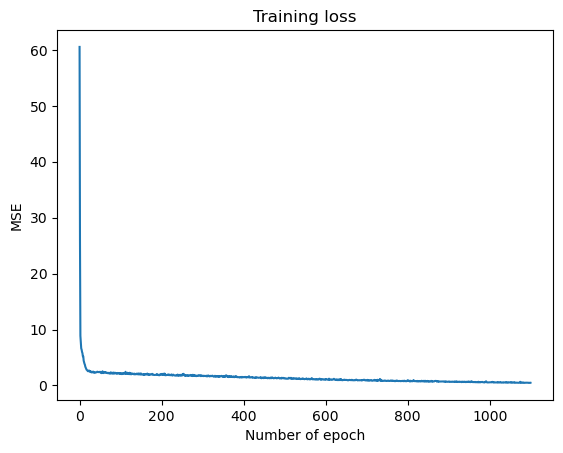

In [530]:
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

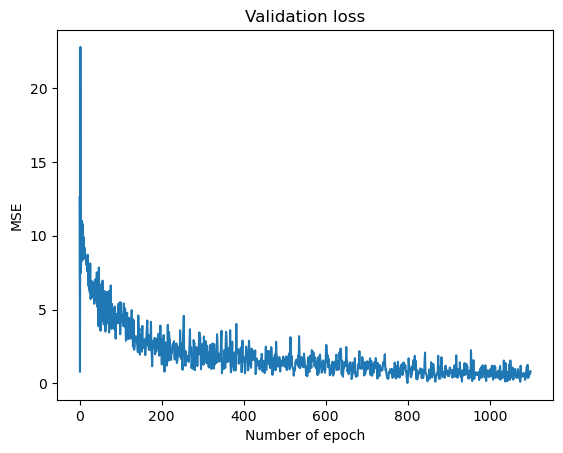

In [531]:
plt.plot([val_losses[i].detach().numpy() for i in range(len(val_losses))])
plt.title('Validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

In [532]:
model(Variable(train_x[15:20]))

tensor([[-8.8409],
        [-7.9352],
        [-6.8541],
        [-4.1925],
        [-9.6255]], grad_fn=<AddmmBackward0>)

In [533]:
Variable(train_y[15:20])

tensor([[ -8.6556],
        [ -7.9208],
        [ -3.7959],
        [ -3.6990],
        [-10.5229]])

In [534]:
file_paths

['/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1e6j.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1eo8.npy',
 '/Users/kevinmicha/Docum

In [535]:
download_path = '/Users/kevinmicha/Downloads/' # or data_path

test_sample = torch.from_numpy(np.load(download_path + '1t66.npy')[:train_x.shape[2], :train_x.shape[2]].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [721]:
model.eval()
10**model(test_sample).detach().numpy()

array([[7.874657e-07]], dtype=float32)

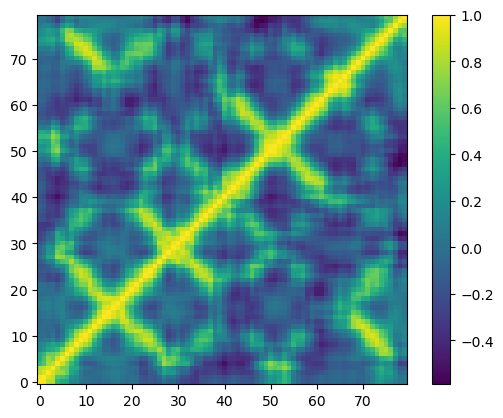

In [537]:
plt.imshow(test_sample[0,0,...], origin='lower')
plt.colorbar()

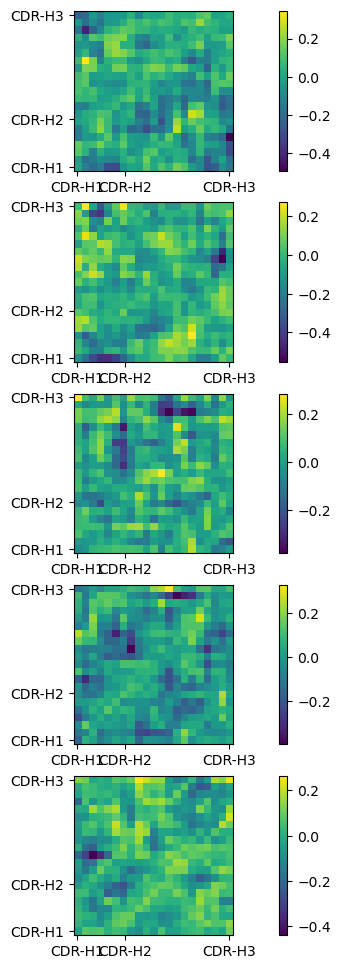

In [544]:
import itertools

fig, axs = plt.subplots(5, 1, figsize=(12, 12))
conv_filters = deepcopy(model.conv1.weight.data.numpy())
                           
for i, j in itertools.product(range(5), range(1)):
    im = axs[i].imshow(conv_filters[i+j][0], origin='lower')
    axs[i].set_xticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])

In [539]:
#fig, axs = plt.subplots(8, 4, figsize=(12, 12))

#for i, j in itertools.product(range(8), range(4)):
#    im = axs[i,j].imshow(model.conv2.weight.data.numpy()[i+j][0], origin='lower')
#    plt.colorbar(im, ax=axs[i, j])


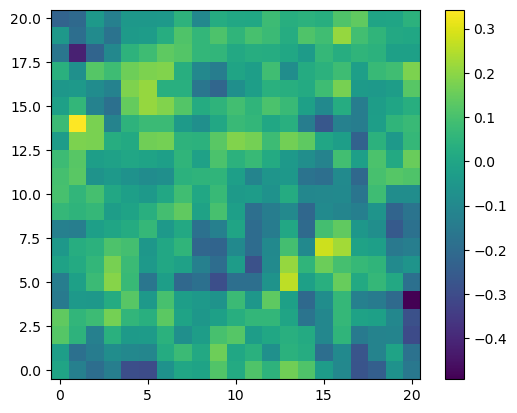

In [545]:
plt.imshow(np.mean(conv_filters[0,...], axis=0), origin='lower')
plt.colorbar()

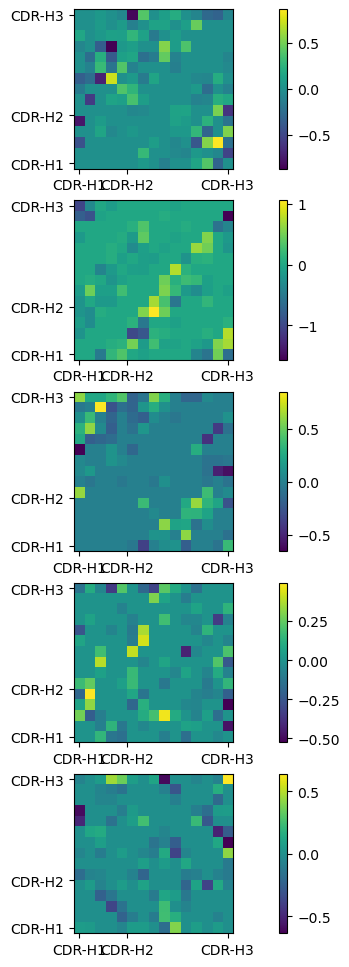

In [601]:
fig, axs = plt.subplots(5, 1, figsize=(12, 12))

fully_connected = deepcopy(model.fc1.weight.data.numpy().reshape(5, 225))
fully_connected = np.where(abs(fully_connected)<0.05, 0, fully_connected)

for i, j in itertools.product(range(5), range(1)):
    im = axs[i].imshow(fully_connected[i+j].reshape(15, 15), origin='lower')
    axs[i].set_xticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])


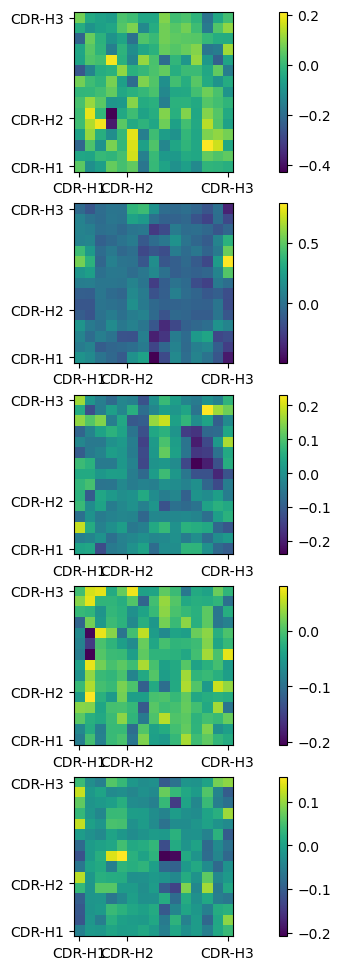

In [607]:
fig, axs = plt.subplots(5, 1, figsize=(12, 12))

img = np.zeros((15, 15))
for i, j in itertools.product(range(5), range(1)):
    new_img = np.dot(cv2.resize(conv_filters[i,0,...], dsize=(15, 15), interpolation=cv2.INTER_CUBIC), fully_connected[i].reshape(15, 15))+model.fc1.bias.detach().numpy()
    im = axs[i].imshow(new_img, origin='lower')
    axs[i].set_xticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 4.5, 14], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])
    img += new_img



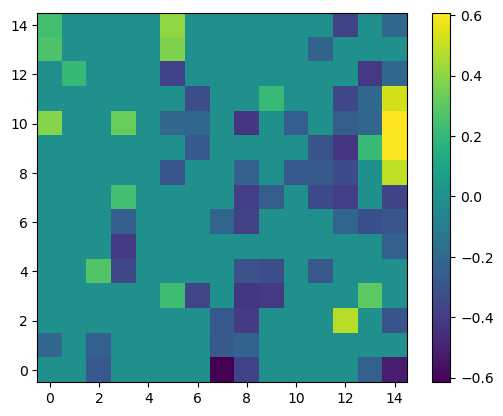

In [609]:
#blue = "need blue in dccm"
#yellow = "need red in dccm"
plt.imshow(np.where(abs(img)<0.2, 0, img), origin='lower')
plt.colorbar()
plt.show()

In [610]:
img.sum()

-14.000475351698697

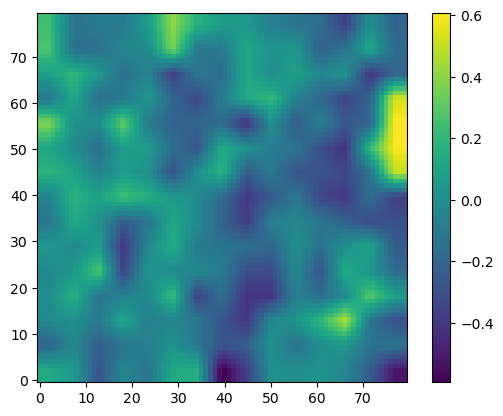

In [807]:
plt.imshow(cv2.resize(img, dsize=(80, 80)), origin='lower')
plt.colorbar()

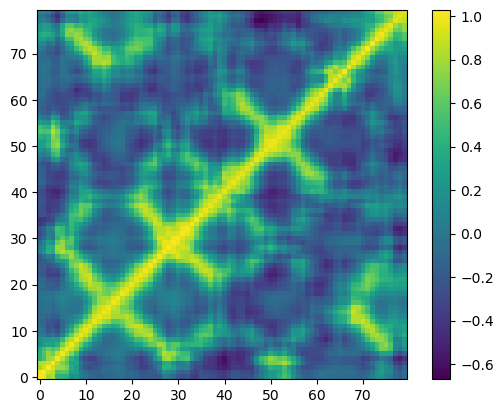

In [810]:
# 1.1303e-05 without adding map
ideal = np.load(data_path + '1fl6.npy')[:train_x.shape[2], :train_x.shape[2]].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32) + 0.2*cv2.resize(img, dsize=(80, 80)).reshape(1, 1, 80, 80)
plt.imshow(ideal[0,0,...], origin='lower')
plt.colorbar()

In [811]:
model.eval()
10**model(torch.from_numpy(ideal.astype(np.float32)))

tensor([[8.9717e-06]], grad_fn=<PowBackward1>)

In [425]:
# Save Neural Network checkpoint
#EPOCH = len(val_losses)
#PATH = "model.pt"
#LOSS = tr_loss

#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, PATH)

In [430]:
# Load Neural Network checkpoint

#PATH = "model.pt"
#model = MultiLabelNN()
#optimizer = AdamW(model.parameters(), lr=4e-4)
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
#10**model(test_sample).detach().numpy()
# - or -
#model.train()

In [27]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")